In [1]:
# importing necessary libraries and setting certain global params
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option("display.max_columns", 50)
%matplotlib inline

# custom functions built for this notebook
import feature_functions as feat

# Initializing the Training and Testing Data

In [2]:
# reading in the cleaned data set
cleaned_county_data = pd.read_csv("data/cleaned_county_health_data.csv")

In [3]:
# defining the target column and and columns of non-feature data
target_var = ["premature_death"]
admin_vars = ["statecode", "countycode", "fipscode",
              "state", "county", "year", "county_ranked"]
feature_vars = list(cleaned_county_data.columns)[8:]

In [4]:
# creating training and testing data
target = cleaned_county_data[target_var]
features = cleaned_county_data.drop(columns=admin_vars+target_var)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(features,
                                                            target,
                                                            random_state=12,
                                                            test_size=.2)

In [5]:
# creating a single training data set for use with some functions
train_raw = pd.merge(y_train, X_train_raw, left_index=True, right_index=True)

# Establishing a Baseline Model
The Baseline model is an ordinary least squares (OLS) regression fit to all 30 non-standardized Health Factors provided by the Robert Wood Johnson Foundation with a target of Premature Death.

In [6]:
# generating the base model with all potential features
formula_base = target_var[0] + '~' + '+'.join(feature_vars)
model_base = ols(formula=formula_base,
                 data=train_raw)
results_base = model_base.fit()
results_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     368.2
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:31:47   Log-Likelihood:                -16295.
No. Observations:                1978   AIC:                         3.265e+04
Df Residuals:                    1947   BIC:                         3.282e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -3972.6721    768.014     -5.173      0.000   -5478.888   -2466.456
adult_smoking                         8524.9713   1047.120      8.141      0.000    6471.376    1.06e+04
adult_obesity                         1557.3197    747.498      2.083      0.037      91.339    3023.301
food_environment_index                -146.1671     35.574     -4.109      0.000    -215.933     -76.401
physical_inactivity                   3380.0388    759.798      4.449      0.000    1889.935    4870.142
access_to_exercise_opportunities      -135.8521    141.248     -0.962      0.336    -412.866     141.161
excessive_drinking                   -5227.9491    948.991     -5.509      0.000   -7089.094   -3366.805
alcohol_impaired_driving_deaths        363.7655    182.517      1.993      0.046       5.816     721.716
sexually_transmitted_infections          0.7603      0.153      4.954      0.000       0.459       1.061
teen_births                             24.4380      2.890      8.455      0.000      18.769      30.107
uninsured                             1324.2286    660.963      2.003      0.045      27.960    2620.497
primary_care_physicians              -6.149e+04   9.49e+04     -0.648      0.517   -2.48e+05    1.25e+05
dentists                               1.39e+04   1.25e+05      0.111      0.912   -2.32e+05     2.6e+05
mental_health_providers               4.435e+04   1.78e+04      2.488      0.013    9393.457    7.93e+04
preventable_hospital_stays               0.0364      0.016      2.339      0.019       0.006       0.067
mammography_screening                 -330.6416    415.591     -0.796      0.426   -1145.692     484.409
flu_vaccinations                       543.6051    315.933      1.721      0.085     -75.997    1163.207
high_school_graduation                1248.4744    354.054      3.526      0.000     554.109    1942.840
some_college                           859.5299    342.856      2.507      0.012     187.127    1531.933
unemployment                          7120.5756   1949.761      3.652      0.000    3296.737    1.09e+04
children_in_poverty                   2679.4263    632.654      4.235      0.000    1438.675    3920.177
income_inequality                      162.6774     43.001      3.783      0.000      78.345     247.010
children_in_single_parent_households  1765.2377    383.788      4.600      0.000    1012.559    2517.916
social_associations                     -9.1883      4.771     -1.926      0.054     -18.545       0.168
violent_crime                            0.2723      0.141      1.925      0.054      -0.005       0.550
injury_deaths                           47.2564      1.218     38.800      0.000      44.868      49.645
air_pollution_particulate_matter      

In [7]:
print('Training Data Baseline Model Results')
print('R-squared = ', results_base.rsquared_adj)
print('RMSE = ', results_base.mse_resid**0.5)

Training Data Baseline Model Results
R-squared =  0.8478283981232845
RMSE =  922.2707010424115


In [8]:
# cross validating the initial baseline model and it looks good
base_reg = LinearRegression()
baseline = cross_val_score(base_reg, X_train_raw, y_train, cv=5)
print(np.mean(baseline))
print(np.std(baseline))

0.8430898097261265
0.005077566652546624


The performance of the baseline model is good, but we'd like to improve or maintain the performance with significantly fewer features to elucidate the most impactful features that should be the focus of insurance providers.

# Standardization

## Standardizing the data
Also converting the data to DataFrames for ease of manipulation.

In [9]:
# Generating standardized data sets as dataframes
scaler = StandardScaler()
scaler.fit(X_train_raw)

X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train = pd.DataFrame(X_train, columns=feature_vars, index=X_train_raw.index)
X_test = pd.DataFrame(X_test, columns=feature_vars, index=X_test_raw.index)

In [10]:
# creating a single training data set with the standardized data
train = pd.merge(y_train, X_train, left_index=True, right_index=True)

# Exploring Correlation and Collinearity
This information helped calibrate our expectations before beginning feature selection.

## Correlation
Plotting a correlation heatmap for all the features and the target for inspection. Correlations are sorted by absolute value of the correlation to the target.

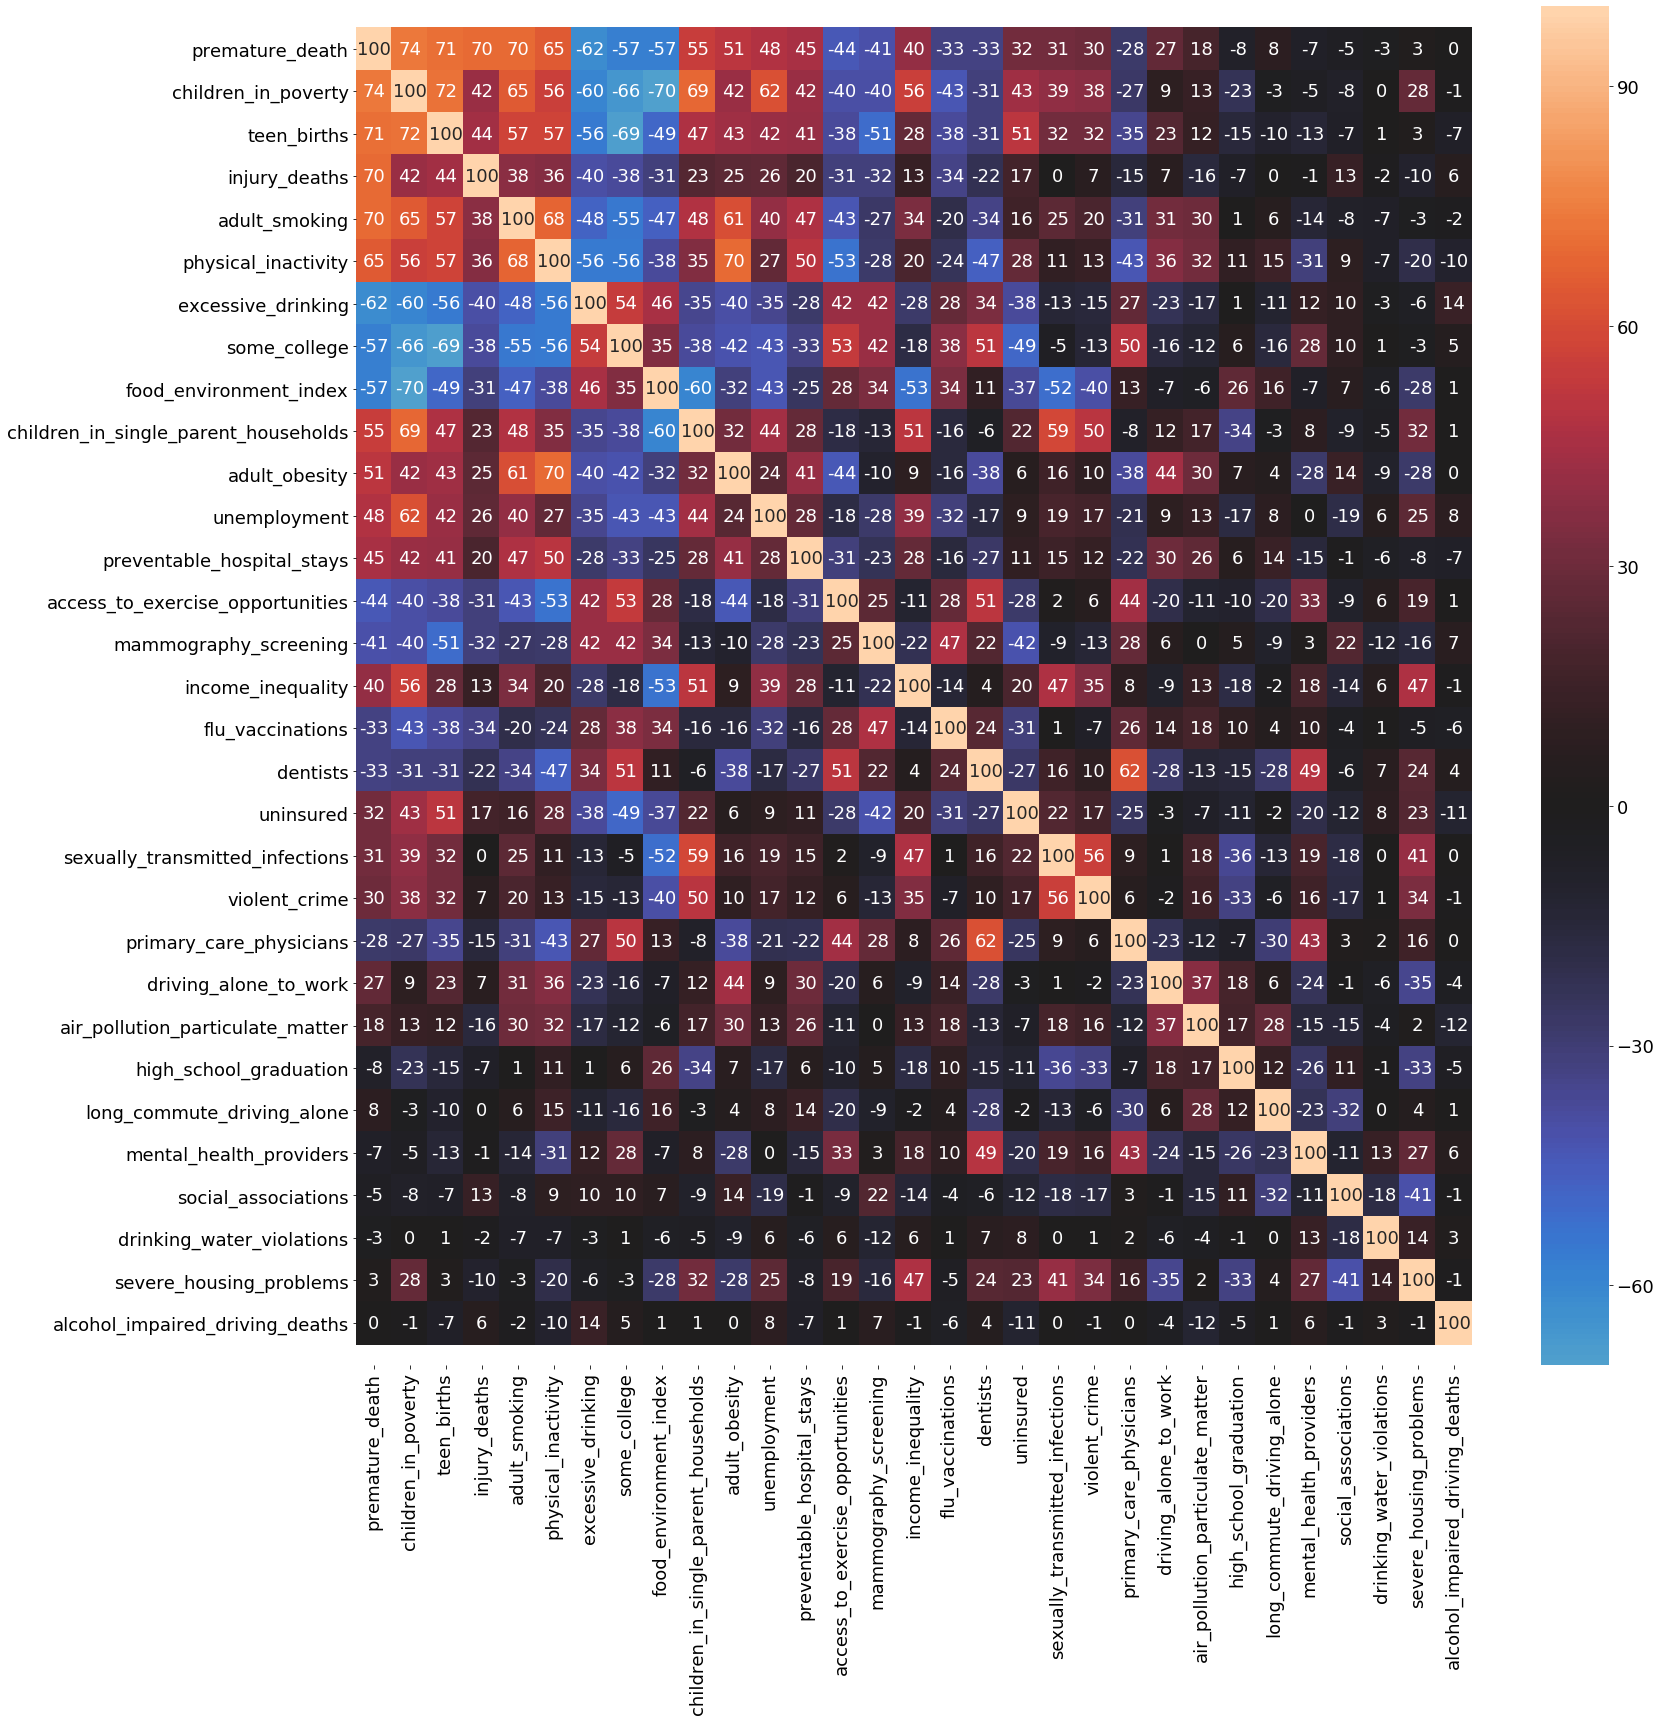

In [11]:
# creating the sort order
sorted_corr_series = train.corr().premature_death.abs().sort_values(ascending=False)
sorted_cols = list(sorted_corr_series.index)

# to allow for larger font sizes,
# the correlations are being rounded and multiplied by 100
sorted_corr_df = train[sorted_cols].corr().round(2)*100

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize = (25, 25))

sns.heatmap(sorted_corr_df.astype(int),
           center = 0, annot = True, fmt="d")

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
ax.set_ylim(len(target_var+feature_vars)+0.5, -0.5);

## Collinearity Evaluation
Nothing is excessively collinear, but children_in_poverty is worrying, and will be monitored. The rule of thumb is to set a cutoff between 5 and 10.

In [12]:
feat.variance_inflation_factor_printout(feature_vars, train)

,Feature,VIF
0,adult_smoking,2.996356
1,adult_obesity,2.716229
2,food_environment_index,2.841101
3,physical_inactivity,3.634129
4,access_to_exercise_opportunities,1.896513
5,excessive_drinking,2.197167
6,alcohol_impaired_driving_deaths,1.098110
7,sexually_transmitted_infections,2.652813
8,teen_births,4.050128
9,uninsured,2.242929


# Feature Selection

## Initial Feature Selection with sklearn's LassoLarsIC()
To eliminate relatively unimpactful features, we implement Lasso (L1) regression with the LARS algorithm for determing a best lambda (i.e. regularization rate) with BIC (Bayesian Information Criterion) as the criterion to optimize (i.e. minimize). A custom function was created to return the coefficients as a dataframe and remaining features as a list after fitting sklearn's LassoLarsIC() function with the data.   
  
This resulted in the coefficients for 14 of the 30 features to be 0.

We also implemented this regression to optimize the AIC (Akaike Information Criterion), but it eliminated fewer features with the same adj. R-squared, so BIC was used moving forward.

In [13]:
bic_df, bic_feats = feat.LassoLarsIC_df(X_train, y_train, 'bic')

## Regression with Initially Remaining Features
An regression is fit to the 16 remaining features after the initial feature selection. Despite removing almost half the original features, the adjusted R-squared value only lowered by 0.003 (0.848 to 0.845). This is a positive sign.

In [14]:
formula_bic = target_var[0] + '~' + '+'.join(bic_feats)
model_bic = ols(formula=formula_bic,
                data=train[target_var+bic_feats])
results_bic = model_bic.fit()
results_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     676.1
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:31:52   Log-Likelihood:                -16318.
No. Observations:                1978   AIC:                         3.267e+04
Df Residuals:                    1961   BIC:                         3.277e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             8257.7947     20.909    394.933      0.000    8216.788    8298.802
adult_smoking                          309.2088     33.974      9.101      0.000     242.579     375.838
adult_obesity                           59.0618     32.034      1.844      0.065      -3.762     121.886
food_environment_index                -158.9492     33.323     -4.770      0.000    -224.301     -93.597
physical_inactivity                    180.7131     38.069      4.747      0.000     106.053     255.373
excessive_drinking                    -172.2672     29.674     -5.805      0.000    -230.462    -114.072
sexually_transmitted_infections        188.4695     30.206      6.239      0.000     129.230     247.709
teen_births                            353.9311     34.853     10.155      0.000     285.578     422.284
preventable_hospital_stays              68.7485     25.963      2.648      0.008      17.831     119.666
unemployment                            81.8216     27.498      2.976      0.003      27.894     135.749
children_in_poverty                    159.3545     50.027      3.185      0.001      61.243     257.466
income_inequality                      125.8219     29.037      4.333      0.000      68.876     182.768
children_in_single_parent_households   142.5049     33.840      4.211      0.000      76.138     208.872
injury_deaths                         1050.4426     25.800     40.715      0.000     999.844    1101.041
air_pollution_particulate_matter       123.8157     26.095      4.745      0.000      72.639     174.993
driving_alone_to_work                  146.6569     25.517      5.747      0.000      96.614     196.700
long_commute_driving_alone             159.0222     23.724      6.703      0.000     112.496     205.548
==============================================================================
Omnibus:                      166.567   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.896
Skew:                           0.458   Prob(JB):                     7.45e-99
Kurtosis:                       5.155   Cond. No.                         6.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
feat.variance_inflation_factor_printout(bic_feats, train)

,Feature,VIF
0,adult_smoking,2.640083
1,adult_obesity,2.347140
2,food_environment_index,2.539830
3,physical_inactivity,3.314849
4,excessive_drinking,2.013996
5,sexually_transmitted_infections,2.086921
6,teen_births,2.778462
7,preventable_hospital_stays,1.541753
8,unemployment,1.729444
9,children_in_poverty,5.724357


To eliminate further features, the p_values of the regression an variance inflation factors of the remaining features were evaluated with thresholds of 0.05 and 5 respectively. Our desire is to only keep statistically significant features that don't show excessive collinearity to help identify the subset of features with the most influence, improve coefficient interpretability, and improve generalizability. 
  
Removed:  
**'adult_obesity'** because its p_value was 0.065.  
**'children_in_poverty'** because it has a variance inflation factor of 5.724133.

## Regression with Remaining Features from the Initial Feature Selection

In [16]:
# removing adult_obesity and children in poverty from the feature list
selected_bic_feats = [bic_feats[0]]+bic_feats[2:9]+bic_feats[10:]

After removing those two features, the adjusted R-squared only dropped by 0.001 (0.845 to 0.844), so their removal will be maintained moving forward.

In [17]:
formula_selected_bic = target_var[0] + '~' + '+'.join(selected_bic_feats)
model_selected_bic = ols(formula=formula_selected_bic,
                            data=train[target_var+selected_bic_feats])
results_selected_bic = model_selected_bic.fit()
results_selected_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     767.2
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:31:52   Log-Likelihood:                -16325.
No. Observations:                1978   AIC:                         3.268e+04
Df Residuals:                    1963   BIC:                         3.276e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             8257.7947     20.970    393.783      0.000    8216.668    8298.921
adult_smoking                          340.3471     32.781     10.382      0.000     276.058     404.636
food_environment_index                -188.4972     32.219     -5.851      0.000    -251.683    -125.311
physical_inactivity                    221.3890     34.355      6.444      0.000     154.013     288.765
excessive_drinking                    -190.3974     29.223     -6.515      0.000    -247.709    -133.085
sexually_transmitted_infections        181.0295     29.913      6.052      0.000     122.364     239.695
teen_births                            390.4547     32.269     12.100      0.000     327.169     453.741
preventable_hospital_stays              75.5376     25.967      2.909      0.004      24.612     126.463
unemployment                           111.8616     26.102      4.286      0.000      60.671     163.052
income_inequality                      140.7224     27.823      5.058      0.000      86.158     195.287
children_in_single_parent_households   183.4854     31.623      5.802      0.000     121.467     245.504
injury_deaths                         1052.9917     25.850     40.735      0.000    1002.296    1103.687
air_pollution_particulate_matter       120.5783     26.147      4.612      0.000      69.300     171.857
driving_alone_to_work                  142.0423     24.578      5.779      0.000      93.840     190.244
long_commute_driving_alone             153.7165     23.700      6.486      0.000     107.237     200.196
==============================================================================
Omnibus:                      169.576   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.860
Skew:                           0.482   Prob(JB):                     5.04e-96
Kurtosis:                       5.097   Cond. No.                         4.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Exploring Interaction Effects
Now that we've reduced the number of features from 30 to 14, we explored whether or not introducing interactions between and square relationships of each feature would improve the model performance without introducing any new underlying county-level metrics.

## Creating the Interaction and Square Features
A function was created that will take a DataFrame of features and return a copy of that DataFrame with new columns for each interation between and the square of each feature.

In [19]:
X_train_inter = feat.add_interactions_and_squares(X_train[selected_bic_feats])

In [20]:
inter_feats_initial = list(X_train_inter.columns)

## Feature Selection with LassoLarsIC() and Interactions/Squares
Repeating the same process of using sklearn's LassoLarsIC() with BIC as the optimization criterion, and then fitting an OLS regression to the features with non-zero coefficients.

In [21]:
inter_df, inter_feats = feat.LassoLarsIC_df(X_train_inter, y_train, 'bic')

In [22]:
train_inter = pd.merge(y_train, X_train_inter, left_index=True, right_index=True)

## Regression with Most Recently Selected Features
An regression is fit to the 17 remaining features after the most recent feature selection. The adjusted R-squared value has now increased by 0.005 (0.844 to 0.849) and the BIC dropped slightly, which is a positive sign. There were also two features that were not statistically significant.

In [23]:
formula_inter = target_var[0] + '~' + '+'.join(inter_feats)
model_inter = ols(formula=formula_inter,
                  data=train_inter[target_var+inter_feats])
results_inter = model_inter.fit()
results_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     655.2
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:31:53   Log-Likelihood:                -16293.
No. Observations:                1978   AIC:                         3.262e+04
Df Residuals:                    1960   BIC:                         3.272e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          8192.2058     22.357    366.427      0.000    8148.360    8236.052
adult_smoking                                       313.6452     32.518      9.645      0.000     249.871     377.419
food_environment_index                             -187.4014     31.958     -5.864      0.000    -250.077    -124.726
physical_inactivity                                 249.0129     34.024      7.319      0.000     182.285     315.741
excessive_drinking                                 -193.5441     28.894     -6.698      0.000    -250.210    -136.879
sexually_transmitted_infections                     130.8527     30.265      4.324      0.000      71.499     190.207
teen_births                                         392.8340     31.825     12.344      0.000     330.420     455.248
preventable_hospital_stays                           50.2232     25.856      1.942      0.052      -0.485     100.931
unemployment                                         95.0354     25.946      3.663      0.000      44.152     145.919
income_inequality                                   130.4092     27.503      4.742      0.000      76.471     184.347
children_in_single_parent_households                239.3827     32.143      7.447      0.000     176.344     302.421
injury_deaths                                      1016.2207     26.259     38.700      0.000     964.722    1067.719
air_pollution_particulate_matter                    139.9487     26.129      5.356      0.000      88.705     191.192
driving_alone_to_work                               131.8648     25.067      5.260      0.000      82.704     181.026
long_commute_driving_alone                          133.2252     23.484      5.673      0.000      87.169     179.281
physical_inactivity_INTERACTION_income_inequality    71.0260     21.753      3.265      0.001      28.364     113.688
teen_births_INTERACTION_injury_deaths                96.8868     21.238      4.562      0.000      55.235     138.538
unemployment_INTERACTION_injury_deaths               34.4683     18.964      1.818      0.069      -2.723      71.660
==============================================================================
Omnibus:                      147.424   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              333.723
Skew:                           0.459   Prob(JB):                     3.41e-73
Kurtosis:                       4.791   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression with only Statistically Significant Features
The regression was repeated after removing the two statistically insignificant features from the last OLS regression.  
  
Removed:  
**'preventable_hospital_stays'** because its p_value was 0.052.  
**'unemployment_INTERACTION_injury_deaths'** because its p_value was 0.069.

In [24]:
# generating a list with those 2 features removed
selected_feats = inter_feats[0:6]+inter_feats[7:-1]

All 15 of the remaining features are statistically significant and the adjusted R-squared hasn't changed. The BIC also dropped slightly. This will be our final model

In [25]:
# evaluating the model without those features
formula_selected_feats = target_var[0] + '~' + '+'.join(selected_feats)
model_selected_feats = ols(formula=formula_selected_feats,
                          data=train_inter[target_var+selected_feats])
results_selected_feats = model_selected_feats.fit()
results_selected_feats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        premature_death   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     740.2
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:31:53   Log-Likelihood:                -16297.
No. Observations:                1978   AIC:                         3.263e+04
Df Residuals:                    1962   BIC:                         3.271e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          8189.2032     22.354    366.335      0.000    8145.362    8233.044
adult_smoking                                       319.7230     32.418      9.863      0.000     256.146     383.300
food_environment_index                             -191.0674     31.783     -6.012      0.000    -253.399    -128.736
physical_inactivity                                 259.9932     33.226      7.825      0.000     194.831     325.155
excessive_drinking                                 -186.2129     28.755     -6.476      0.000    -242.607    -129.819
sexually_transmitted_infections                     131.9276     30.261      4.360      0.000      72.580     191.275
teen_births                                         398.1142     31.560     12.615      0.000     336.220     460.008
unemployment                                        103.2656     25.754      4.010      0.000      52.757     153.774
income_inequality                                   137.9531     27.151      5.081      0.000      84.706     191.201
children_in_single_parent_households                235.2763     32.068      7.337      0.000     172.385     298.168
injury_deaths                                      1021.7806     26.085     39.171      0.000     970.623    1072.938
air_pollution_particulate_matter                    139.7817     26.097      5.356      0.000      88.602     190.961
driving_alone_to_work                               138.7035     24.901      5.570      0.000      89.868     187.539
long_commute_driving_alone                          137.6929     23.426      5.878      0.000      91.751     183.635
physical_inactivity_INTERACTION_income_inequality    79.5321     21.538      3.693      0.000      37.292     121.772
teen_births_INTERACTION_injury_deaths               120.4453     17.728      6.794      0.000      85.678     155.213
==============================================================================
Omnibus:                      150.745   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.819
Skew:                           0.462   Prob(JB):                     1.80e-76
Kurtosis:                       4.838   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Reviewing Model Performance and Assumptions

## Cross Validation of the Final Model
Cross-validating a regression with the final selection of features. The model continues to perform better than the baseline model with far fewer features, but the standard deviation among the models has increased, so it may be more over-fit than the baseline model.

In [26]:
final_reg = LinearRegression()
final_cvs = cross_val_score(final_reg, X_train_inter[selected_feats], y_train, cv=10)
print(np.mean(final_cvs))
print(np.std(final_cvs))

0.8458454874376777
0.01692385857150239


## Evaluating Normality Assumption
The quarter-quantile plot of the residuals shows some deviation from normailty among the highest residuals.

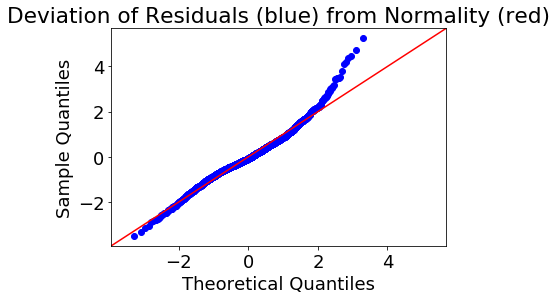

In [27]:
sm.graphics.qqplot(results_selected_feats.resid, dist=stats.norm, line='45', fit=True)
plt.title("Deviation of Residuals (blue) from Normality (red)")
plt.savefig('normality_qqplot.png')
plt.show();

## Evaluating the Homoscedasticity Assumption
Plotting the variance of residuals shows a mostly uniform distribution with more variance among the highest predicted values and less among the lowest predicted values.

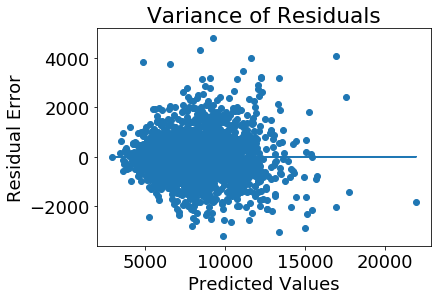

In [28]:
plt.scatter(results_selected_feats.predict(X_train_inter[selected_feats]),
            results_selected_feats.resid)
plt.plot(results_selected_feats.predict(X_train_inter[selected_feats]),
         [0 for i in range(len(X_train_inter))])
plt.title("Variance of Residuals")
plt.xlabel('Predicted Values')
plt.ylabel('Residual Error')
plt.savefig('residuals_variance.png')
plt.show();

## Evaluating the Collinearity Assumption
The Variance Inflation Factors are all below 3 with anything above 5-10 being problematic, so there is no significant collinearity and the coefficients can be considered interpretable.

In [29]:
feat.variance_inflation_factor_printout(selected_feats, X_train_inter)

,Feature,VIF
0,adult_smoking,2.452594
1,food_environment_index,2.361968
2,physical_inactivity,2.579952
3,excessive_drinking,1.933504
4,sexually_transmitted_infections,2.128751
5,teen_births,2.329101
6,unemployment,1.550253
7,income_inequality,1.722389
8,children_in_single_parent_households,2.389991
9,injury_deaths,1.585665


# Evaluating the Model with Unseen Test Data

## Predict the Test Data with the Baseline and Final Model
The first step is to create the interaction features from the test data. Then the predictions can be made for both models.

In [33]:
X_test_inter = feat.add_interactions_and_squares(X_test[selected_bic_feats])

In [34]:
selected_test_predictions = results_selected_feats.predict(X_test_inter[selected_feats])

In [35]:
base_predictions = results_base.predict(X_test_raw)

## Reviewing Prediction Quality of the Baseline and Final Models with the Training and Testing Data 
The Final model performed better than the Baseline model on the Training data. The Final model performed slightly worse than the Baseline model on the Testing data. Considering the closeness of the results we will accept that our final selection of features are a high quality subset of the initial features, which insurance providers can focus on within the geographic areas that they serve.

In [36]:
print('Training Data Baseline Model Results')
print('R-squared = ', results_base.rsquared_adj)
print('RMSE = ', results_base.mse_resid**0.5)

Training Data Baseline Model Results
R-squared =  0.8478283981232845
RMSE =  922.2707010424115


In [37]:
print('Testing Data Baseline Model Results')
print('R-squared = ', r2_score(y_test.iloc[:,0],base_predictions))
print('RMSE = ', mean_squared_error(y_test.iloc[:,0], base_predictions)**0.5)

Testing Data Baseline Model Results
R-squared =  0.838523602070273
RMSE =  971.514715643755


In [38]:
print('Training Data Final Model Results')
print('R-squared = ', results_selected_feats.rsquared_adj)
print('RMSE = ', results_selected_feats.mse_resid**0.5)

Training Data Final Model Results
R-squared =  0.8486789252328467
RMSE =  919.6896827218344


In [39]:
print('Testing Data Final Model Results')
print('R-squared = ', r2_score(y_test.iloc[:,0],selected_test_predictions))
print('RMSE = ', mean_squared_error(y_test.iloc[:,0], selected_test_predictions)**0.5)

Testing Data Final Model Results
R-squared =  0.8374052765542971
RMSE =  974.8730858890168


# Conclusions
- County-level health can be accurately predicted with a relatively small subset of factors.  
- Many of these are not directly related to the local healthcare system, but socio-economic and behavioural phenomena.  
- Insurance providers should focus on using this information for identifying healthy and unhealthy populations for geographic premium rate adjustments.  